In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from efficientnet_pytorch import EfficientNet
#import xgboost as xgb

from PIL import Image
from skimage.transform import resize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from scipy.stats import ks_2samp

from sklearn.utils.class_weight import compute_class_weight

from tqdm import tqdm

In [2]:
# Device configuration (GPU can be enabled in settings)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [3]:
# upload train dataframe
path = "../../data-256/"
train_df_allsamples = pd.read_csv(path+"train.csv")
train_df_allsamples.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [4]:
# upload train dataframe
test_df = pd.read_csv(path + 'test.csv')
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080


# TFRecord describes stratified k-fold to keep counts of patient replicates evenly distributed within each fold

Some patients have as many as 115 images - to keep validation more representative of a real testing scenario, training and validation should not share images from the same patient. Furthermore, the number of replicates from each patient should be similar in each fold. The tfrecord column in the data table provides a k-fold partitioning scheme that keeps replicates even distributed in each fold. 

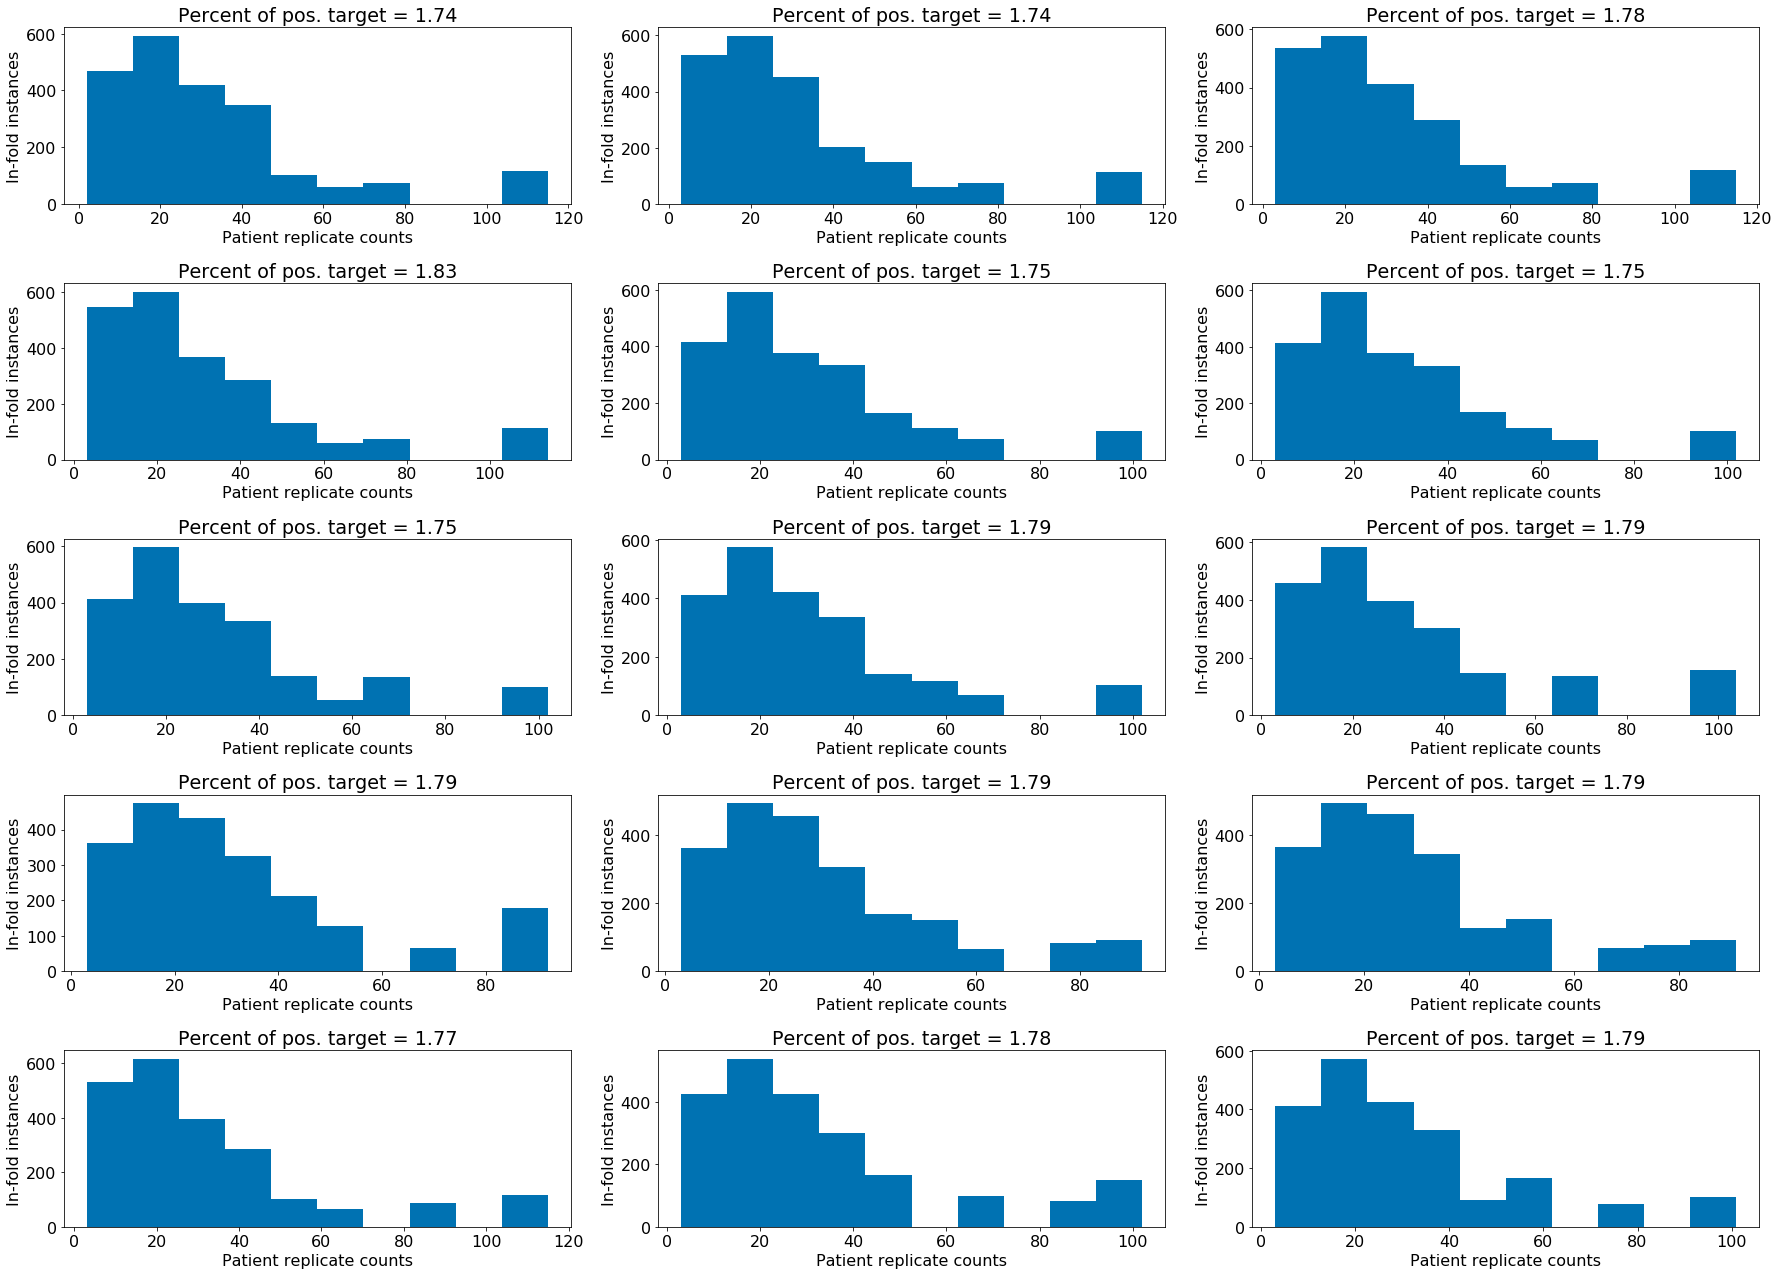

In [5]:
unique_patient_ids, patient_counts = np.unique(train_df_allsamples['patient_id'].values, return_counts=True)
patient_to_count = {p_id:count for p_id, count in zip(unique_patient_ids, patient_counts)}

tfrecords = train_df_allsamples['tfrecord'].values 
folds = np.arange(15)

plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16,
                     'legend.framealpha':.5,
                     'legend.edgecolor':'k',
                     'axes.edgecolor':'k'})
plt.figure(figsize=(5*5, 6*3))
k = 1 
for f in folds:
    fold_df = train_df_allsamples.iloc[tfrecords == folds[f], :]

    fold_patient_ids = fold_df['patient_id'].values 
    fold_patient_counts = [patient_to_count[p] for p in fold_patient_ids]
    fold_target = fold_df['target'].values
    fold_p_target = 100 * sum(fold_target) / len(fold_target)

    plt.subplot(5, 3, k)
    k += 1
    plt.hist(fold_patient_counts)
    plt.xlabel("Patient replicate counts")
    plt.ylabel("In-fold instances")
    plt.title("Percent of pos. target = {:.2f}".format(fold_p_target))
    
plt.tight_layout()
plt.show()

In [6]:
meta_features = ['sex', 'age_approx', 'anatom_site_general_challenge'] 

encoder = {}
for feature in meta_features: 
    # determine unique features  
    categories = np.unique(np.array(train_df_allsamples[feature].values, str))
    for i, category in enumerate(categories): 
        if category != 'nan':
            encoder[category] = np.float(i)
encoder['nan'] = np.nan

# define a unique transform each time a positive is resampled: 

# basic transform for all images 
transform_basic = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=8),
    transforms.ColorJitter(brightness=32. / 255.,saturation=0.5),
    transforms.RandomResizedCrop(size=256, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.ToTensor()])

# additional transform to augment positive samples 
transform_augment_h = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomResizedCrop(size=256, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(1),
    transforms.ToTensor()])
transform_augment_v = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.RandomResizedCrop(size=256, scale=(0.9, 1.1), ratio=(0.9, 1.1)),
    transforms.RandomVerticalFlip(1),
    transforms.ToTensor()])

# no flip or rotation for test/validation data 
transform_valid = transforms.Compose([
    transforms.ToTensor()])  

class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_name'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path) 
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        label_encode = np.zeros(2)
        label_encode[label] = 1
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform) 
        img_processed = transform_basic(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

class ValidDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        
        # load X 
        img_name = self.df['image_name'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path) 
        
        # determine meta data 
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])
        
        # load y 
        label = self.df["target"].values[index]
        label_encode = np.zeros(2)
        label_encode[label] = 1
        target = torch.tensor(label, dtype=torch.float32)
        
        # 2. Preprocess the data (e.g. torchvision.Transform)
        img_processed = transform_valid(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data, target
        
    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, path_to_files):
        # 1. Initialize file paths or a list of file names.
        self.path = path_to_files
        self.df = df

    def __getitem__(self, index):
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).

        # load X
        img_name = self.df['image_name'].values[index]
        img_path = self.path + img_name + ".jpg"
        img = plt.imread(img_path)

        # determine meta data
        meta = self.df[meta_features].values[index]
        meta_data = np.array([encoder[str(m)] for m in meta])

        # 2. Preprocess the data (e.g. torchvision.Transform)
        img_processed = transform_valid(img)
        # 3. Return a data pair (e.g. image and label).
        return img_processed, meta_data

    def __len__(self):
        # total size of your dataset.
        return self.df.shape[0]

def AugmentBatch(images, labels):
    
    # find positives in data set 
    for img, label in zip(images, labels):
        if label == 1:
            # transform image with horizontal flip
            img_aug = transform_augment_h(img).unsqueeze_(0)
            # append set of augmented images and labels 
            images = torch.cat((images, img_aug)) 
            labels = torch.cat((labels, torch.Tensor([label])))
            
            # transform image with vertical flip
            img_aug = transform_augment_v(img).unsqueeze_(0)
            # append set of augmented images and labels 
            images = torch.cat((images, img_aug)) 
            labels = torch.cat((labels, torch.Tensor([label])))

    # shuffle 
    shuffle_inds = torch.randperm(images.size()[0])
    images = images[shuffle_inds, :, :, :]
    labels = labels[shuffle_inds]
    return images, labels

In [7]:
# First, load the EfficientNet with pre-trained parameters 
# ENet = EfficientNet.from_pretrained('efficientnet-b0').to(device)

# Convolutional neural network
class MyENet(nn.Module):
    def __init__(self, ENet):
        super(MyENet, self).__init__()
        # modify output layer of the pre-trained ENet 
        self.ENet = ENet
        num_ftrs = self.ENet._fc.in_features
        self.ENet._fc = nn.Linear(in_features=num_ftrs, out_features=512)
        # map Enet output to melanoma decision 
        self.output = nn.Sequential(nn.BatchNorm1d(512),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=0.2),
                                    nn.Linear(512, 1),
                                    nn.Sigmoid())
        
    def embedding(self, x):
        out = self.ENet(x)
        return out 
        
    def forward(self, x):
        out = self.ENet(x)
        out = self.output(out)
        return out

In [8]:
# 2 convolutional layers + 2 fully connected layers 
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(),  
            nn.Dropout(p=0.4),
            nn.AvgPool2d(kernel_size=4, stride=4))
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4),
            nn.AvgPool2d(kernel_size=8, stride=8)) 
        self.fc = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Dropout(p=0.4))
        self.output = nn.Sequential(
            nn.Linear(512, 1),
            nn.Sigmoid())
        
    def embedding(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        #out = self.fc(out)
        return out 
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.output(out)
        return out

In [9]:
# weight positive examples more heavily
def make_weights(targets):
    nclasses = len(np.unique(targets))
    count = [0] * nclasses
    for label in targets:
        count[np.int(label)] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(targets)
    for idx, label in enumerate(targets):
        weight[idx] = weight_per_class[np.int(label)]

    return np.array(weight)

# define function to fit and return xgboost model
def fit_xgboost(X_train, y_train, X_val, y_val):

    # weight positive examples more heavily
    w = make_weights(y_train)

    dtrain = xgb.DMatrix(X_train, label=y_train, weight=w)
    dval = xgb.DMatrix(X_val, label=y_val)

    # booster params
    param = {'n_estimators':5000,
            'max_depth':16,
            'learning_rate':0.02,
            'subsample':0.8,
            'eval_metric':'auc',
            'objective': 'binary:logistic',
            'nthread': 8}

    # specify validation set
    evallist = [(dval, 'eval')]

    # Training
    num_round = 5000
    bst = xgb.train(param, dtrain, num_round, evals=evallist, early_stopping_rounds=5)

    return bst


Fold [1/15], Epoch [1/5], Step [10/222], ROC AUC: 0.404, Loss: 0.289, K-S stat: 0.305


Fold [1/15], Epoch [1/5], Step [20/222], ROC AUC: 0.643, Loss: 0.315, K-S stat: 0.328


Fold [1/15], Epoch [1/5], Step [30/222], ROC AUC: 0.664, Loss: 0.191, K-S stat: 0.551


Fold [1/15], Epoch [1/5], Step [50/222], ROC AUC: 0.763, Loss: 0.188, K-S stat: 0.602


Fold [1/15], Epoch [1/5], Step [60/222], ROC AUC: 0.716, Loss: 0.189, K-S stat: 0.551


Fold [1/15], Epoch [1/5], Step [70/222], ROC AUC: 0.574, Loss: 0.272, K-S stat: 0.333


Fold [1/15], Epoch [1/5], Step [80/222], ROC AUC: 0.690, Loss: 0.317, K-S stat: 0.440


Fold [1/15], Epoch [1/5], Step [100/222], ROC AUC: 0.843, Loss: 0.105, K-S stat: 0.824


Fold [1/15], Epoch [1/5], Step [110/222], ROC AUC: 0.641, Loss: 0.269, K-S stat: 0.325


Fold [1/15], Epoch [1/5], Step [120/222], ROC AUC: 0.689, Loss: 0.192, K-S stat: 0.551


Fold [1/15], Epoch [1/5], Step [130/222], ROC AUC: 0.683, Loss: 0.301, K-S stat: 0.431


Fold [1/15], Epoch [1/5], S

..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.



Fold [1/15], Epoch [1/5], Val ROC AUC: 0.823, Val K-S stat: 0.534


Fold [1/15], Epoch [2/5], Step [10/222], ROC AUC: 0.657, Loss: 0.191, K-S stat: 0.390


Fold [1/15], Epoch [2/5], Step [20/222], ROC AUC: 0.728, Loss: 0.330, K-S stat: 0.477


Fold [1/15], Epoch [2/5], Step [30/222], ROC AUC: 0.946, Loss: 0.148, K-S stat: 0.839


Fold [1/15], Epoch [2/5], Step [50/222], ROC AUC: 0.781, Loss: 0.177, K-S stat: 0.579


Fold [1/15], Epoch [2/5], Step [60/222], ROC AUC: 0.871, Loss: 0.161, K-S stat: 0.706


Fold [1/15], Epoch [2/5], Step [70/222], ROC AUC: 0.619, Loss: 0.265, K-S stat: 0.308


Fold [1/15], Epoch [2/5], Step [80/222], ROC AUC: 0.679, Loss: 0.335, K-S stat: 0.302


Fold [1/15], Epoch [2/5], Step [100/222], ROC AUC: 0.325, Loss: 0.145, K-S stat: 0.529


Fold [1/15], Epoch [2/5], Step [110/222], ROC AUC: 0.728, Loss: 0.247, K-S stat: 0.496


Fold [1/15], Epoch [2/5], Step [120/222], ROC AUC: 0.780, Loss: 0.170, K-S stat: 0.568


Fold [1/15], Epoch [2/5], Step [130/222], ROC AU

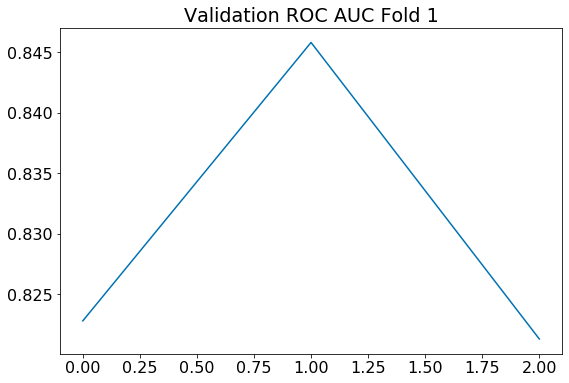


Fold [2/15], Epoch [1/5], Step [10/222], ROC AUC: 0.727, Loss: 0.184, K-S stat: 0.669


Fold [2/15], Epoch [1/5], Step [20/222], ROC AUC: 0.510, Loss: 0.148, K-S stat: 0.429


Fold [2/15], Epoch [1/5], Step [40/222], ROC AUC: 0.283, Loss: 0.137, K-S stat: 0.563


Fold [2/15], Epoch [1/5], Step [50/222], ROC AUC: 0.758, Loss: 0.174, K-S stat: 0.636


Fold [2/15], Epoch [1/5], Step [60/222], ROC AUC: 0.597, Loss: 0.274, K-S stat: 0.350


Fold [2/15], Epoch [1/5], Step [70/222], ROC AUC: 0.945, Loss: 0.140, K-S stat: 0.839


Fold [2/15], Epoch [1/5], Step [80/222], ROC AUC: 0.972, Loss: 0.085, K-S stat: 0.950


Fold [2/15], Epoch [1/5], Step [90/222], ROC AUC: 0.733, Loss: 0.249, K-S stat: 0.385


Fold [2/15], Epoch [1/5], Step [100/222], ROC AUC: 0.798, Loss: 0.148, K-S stat: 0.748


Fold [2/15], Epoch [1/5], Step [110/222], ROC AUC: 0.784, Loss: 0.325, K-S stat: 0.486


Fold [2/15], Epoch [1/5], Step [120/222], ROC AUC: 0.836, Loss: 0.172, K-S stat: 0.797


Fold [2/15], Epoch [1/5], St

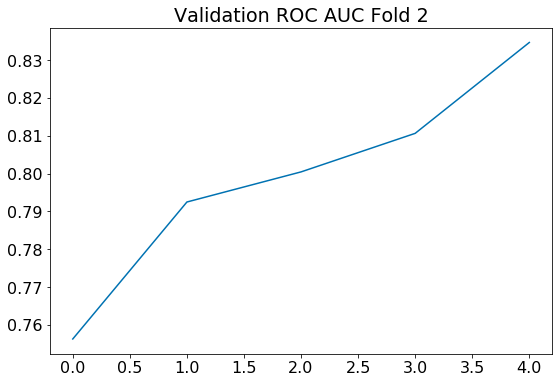


Fold [3/15], Epoch [1/5], Step [10/222], ROC AUC: 0.305, Loss: 0.229, K-S stat: 0.622


Fold [3/15], Epoch [1/5], Step [20/222], ROC AUC: 0.653, Loss: 0.479, K-S stat: 0.292


Fold [3/15], Epoch [1/5], Step [30/222], ROC AUC: 0.579, Loss: 0.207, K-S stat: 0.322


Fold [3/15], Epoch [1/5], Step [40/222], ROC AUC: 0.644, Loss: 0.194, K-S stat: 0.367


Fold [3/15], Epoch [1/5], Step [50/222], ROC AUC: 0.640, Loss: 0.265, K-S stat: 0.410


Fold [3/15], Epoch [1/5], Step [60/222], ROC AUC: 0.743, Loss: 0.347, K-S stat: 0.522


Fold [3/15], Epoch [1/5], Step [70/222], ROC AUC: 0.828, Loss: 0.220, K-S stat: 0.667


Fold [3/15], Epoch [1/5], Step [80/222], ROC AUC: 0.814, Loss: 0.357, K-S stat: 0.559


Fold [3/15], Epoch [1/5], Step [100/222], ROC AUC: 0.816, Loss: 0.282, K-S stat: 0.560


Fold [3/15], Epoch [1/5], Step [110/222], ROC AUC: 0.826, Loss: 0.122, K-S stat: 0.790


Fold [3/15], Epoch [1/5], Step [120/222], ROC AUC: 0.757, Loss: 0.172, K-S stat: 0.508


Fold [3/15], Epoch [1/5], St


Fold [3/15], Epoch [5/5], Val ROC AUC: 0.836, Val K-S stat: 0.529

Creating training data for xgb model
Creating validation data for xgb model
Creating testing data for xgb model

Fold [3/15], XGB Val ROC AUC: 0.810, XGB Val K-S stat: 0.465



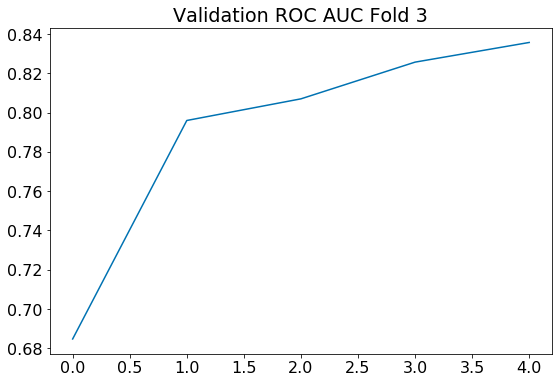


Fold [4/15], Epoch [1/5], Step [10/222], ROC AUC: 0.870, Loss: 0.147, K-S stat: 0.788


Fold [4/15], Epoch [1/5], Step [40/222], ROC AUC: 0.716, Loss: 0.287, K-S stat: 0.460


Fold [4/15], Epoch [1/5], Step [50/222], ROC AUC: 0.429, Loss: 0.140, K-S stat: 0.479


Fold [4/15], Epoch [1/5], Step [60/222], ROC AUC: 0.895, Loss: 0.210, K-S stat: 0.769


Fold [4/15], Epoch [1/5], Step [70/222], ROC AUC: 0.775, Loss: 0.224, K-S stat: 0.564


Fold [4/15], Epoch [1/5], Step [80/222], ROC AUC: 0.667, Loss: 0.321, K-S stat: 0.371


Fold [4/15], Epoch [1/5], Step [90/222], ROC AUC: 0.768, Loss: 0.120, K-S stat: 0.731


Fold [4/15], Epoch [1/5], Step [100/222], ROC AUC: 0.903, Loss: 0.144, K-S stat: 0.839


Fold [4/15], Epoch [1/5], Step [110/222], ROC AUC: 0.927, Loss: 0.144, K-S stat: 0.814


Fold [4/15], Epoch [1/5], Step [120/222], ROC AUC: 0.563, Loss: 0.124, K-S stat: 0.546


Fold [4/15], Epoch [1/5], Step [130/222], ROC AUC: 0.868, Loss: 0.128, K-S stat: 0.773


Fold [4/15], Epoch [1/5], S


Fold [4/15], Epoch [5/5], Step [220/222], ROC AUC: 0.867, Loss: 0.298, K-S stat: 0.617


Fold [4/15], Epoch [5/5], Val ROC AUC: 0.777, Val K-S stat: 0.425

Creating training data for xgb model
Creating validation data for xgb model
Creating testing data for xgb model

Fold [4/15], XGB Val ROC AUC: 0.813, XGB Val K-S stat: 0.483



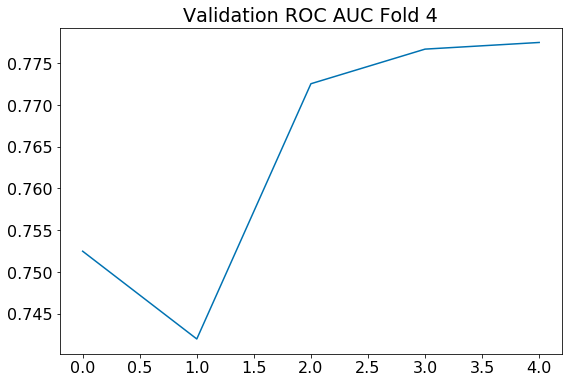


Fold [5/15], Epoch [1/5], Step [10/222], ROC AUC: 0.534, Loss: 0.208, K-S stat: 0.373


Fold [5/15], Epoch [1/5], Step [20/222], ROC AUC: 0.806, Loss: 0.177, K-S stat: 0.602


Fold [5/15], Epoch [1/5], Step [30/222], ROC AUC: 0.684, Loss: 0.185, K-S stat: 0.542


Fold [5/15], Epoch [1/5], Step [40/222], ROC AUC: 0.740, Loss: 0.176, K-S stat: 0.576


Fold [5/15], Epoch [1/5], Step [50/222], ROC AUC: 0.751, Loss: 0.183, K-S stat: 0.627


Fold [5/15], Epoch [1/5], Step [60/222], ROC AUC: 0.451, Loss: 0.152, K-S stat: 0.521


Fold [5/15], Epoch [1/5], Step [70/222], ROC AUC: 0.832, Loss: 0.106, K-S stat: 0.739


Fold [5/15], Epoch [1/5], Step [80/222], ROC AUC: 0.464, Loss: 0.466, K-S stat: 0.293


Fold [5/15], Epoch [1/5], Step [90/222], ROC AUC: 0.790, Loss: 0.172, K-S stat: 0.568


Fold [5/15], Epoch [1/5], Step [100/222], ROC AUC: 0.335, Loss: 0.253, K-S stat: 0.483


Fold [5/15], Epoch [1/5], Step [110/222], ROC AUC: 0.700, Loss: 0.133, K-S stat: 0.681


Fold [5/15], Epoch [1/5], Ste


Fold [5/15], Epoch [5/5], Step [60/222], ROC AUC: 0.863, Loss: 0.098, K-S stat: 0.807


Fold [5/15], Epoch [5/5], Step [70/222], ROC AUC: 0.725, Loss: 0.117, K-S stat: 0.681


Fold [5/15], Epoch [5/5], Step [80/222], ROC AUC: 0.784, Loss: 0.290, K-S stat: 0.560


Fold [5/15], Epoch [5/5], Step [90/222], ROC AUC: 0.866, Loss: 0.145, K-S stat: 0.630


Fold [5/15], Epoch [5/5], Step [100/222], ROC AUC: 0.554, Loss: 0.217, K-S stat: 0.246


Fold [5/15], Epoch [5/5], Step [110/222], ROC AUC: 0.888, Loss: 0.100, K-S stat: 0.874


Fold [5/15], Epoch [5/5], Step [120/222], ROC AUC: 0.779, Loss: 0.107, K-S stat: 0.647


Fold [5/15], Epoch [5/5], Step [130/222], ROC AUC: 0.922, Loss: 0.089, K-S stat: 0.840


Fold [5/15], Epoch [5/5], Step [140/222], ROC AUC: 0.712, Loss: 0.189, K-S stat: 0.508


Fold [5/15], Epoch [5/5], Step [150/222], ROC AUC: 0.950, Loss: 0.161, K-S stat: 0.829


Fold [5/15], Epoch [5/5], Step [160/222], ROC AUC: 0.734, Loss: 0.115, K-S stat: 0.605


Fold [5/15], Epoch [5/5]

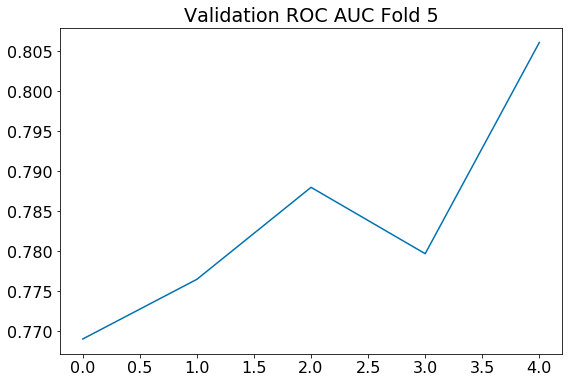

In [10]:
# Train the model
# Use the prebuilt data loader.
train_path = path + "train/"
test_path = path + "test/"
path_to_model = '../Models/model.ckpt'

# define batch size and accumulation steps 
num_epochs = 5
batchsize  = 120
accumulation_steps = 1 # ~ sort of like making an effective batchsize = acc.steps * batchsize ? 
evaluation_steps = 10
set_patience = 1 
best_val     = 0
verbose = True
        
# record out-of-fold predictions and test predictions 
nn_oof = np.zeros(len(train_df_allsamples))
predictions = np.zeros(len(test_df))

# create a test loader 
test_dataset = TestDataset(test_df, test_path)                                              
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batchsize) 

# update folds to 5 sets of inds 
fold_sets = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [9, 10, 11], [12, 13, 14]]

# loop through every fold 
for f, fold_set in enumerate(fold_sets):
    # initialize new model for each fold 
    # model = MyENet(ENet).to(device)
    model = ConvNet().to(device)
    
    # define lr and optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()
    
    # scheduler reduces learning rate by factor of 10 when val auc does not improve
    scheduler = ReduceLROnPlateau(optimizer=optimizer, min_lr=3e-6, mode='max', patience=0, verbose=True)
    
    # pull the training and validation data for each fold
    inds = np.in1d(tfrecords, np.array(fold_set))
    train_df = train_df_allsamples.iloc[~inds, :]
    val_df = train_df_allsamples.iloc[inds, :]

    # evaluate performance on validation data 
    train_dataset = TrainDataset(train_df, train_path)                                              
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batchsize, shuffle=True) 
    
    # evaluate performance on validation data 
    valid_dataset = ValidDataset(val_df, train_path)                                              
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batchsize, shuffle=False) 
    
    # save validation statistics 
    val_roc = []
    val_ks_stat = []
    
    # Reset gradients
    for epoch in range(num_epochs):
        
        # set up model for training     
        model.train()
        for i, (images, meta_data, labels) in enumerate(train_loader):

            # augment the batch with more positive samples 
            images, labels = AugmentBatch(images, labels)
            
            # send images and labels to gpu or cpu RAM 
            images = images.to(device)
            labels = torch.reshape(labels, [len(labels), 1])
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)   
            
            # Compute loss 
            loss = criterion(outputs, labels)
            loss = loss / accumulation_steps                # Normalize loss (if averaged)
            loss.backward()                                 # Backward pass
            if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
                optimizer.step()                            # Now we can do an optimizer step
                model.zero_grad()                           # Reset gradients tensors
            
            # calculate performance 
            train_targets = np.array(labels.cpu().numpy(), np.int)
            train_predictions = outputs.detach().cpu().numpy().ravel()

            # if positive samples existed in batch 
            if sum(train_targets)[0] > 0:
                fpr, tpr, _ = roc_curve(train_targets, train_predictions)
                roc = auc(fpr, tpr)
                
                ks_stat, p = ks_2samp(np.array(train_predictions).ravel()[np.array(train_targets).ravel()==0], 
                                   np.array(train_predictions).ravel()[np.array(train_targets).ravel()==1])

                if verbose and (i+1) % evaluation_steps == 0:
                    # Print performance on minibatch train data 
                    print ('\nFold [{}/{}], Epoch [{}/{}], Step [{}/{}], ROC AUC: {:.3f}, Loss: {:.3f}, K-S stat: {:.3f}\n'
                       .format(f+1, len(folds), epoch+1, num_epochs, i+1, len(train_loader), roc, loss.detach().cpu().numpy(), ks_stat))
                
        
        # Evaluate validation data at end of each epoch
        valid_predictions = []
        valid_targets = []
        model.eval() 
        with torch.no_grad():
            for j, (images, meta_data, labels) in enumerate(valid_loader):
                images = images.to(device)

                labels = torch.reshape(labels, [len(labels), 1])
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)

                # Calculate val ROC
                valid_predictions += list(outputs.detach().cpu().numpy())
                valid_targets += list(labels.cpu().numpy())

        # Calculate performance statistics on validation data 
        fpr, tpr, _ = roc_curve(np.array(valid_targets, np.int), np.array(valid_predictions).ravel())
        val_roc_epoch = auc(fpr, tpr)
        val_roc.append(val_roc_epoch)
        val_ks_stat_epoch, p = ks_2samp(np.array(valid_predictions).ravel()[np.array(valid_targets).ravel()==0], 
                                        np.array(valid_predictions).ravel()[np.array(valid_targets).ravel()==1])
        val_ks_stat.append(val_ks_stat_epoch)

        print('\nFold [{}/{}], Epoch [{}/{}], Val ROC AUC: {:.3f}, Val K-S stat: {:.3f}\n'
               .format(f+1, len(folds), epoch+1, num_epochs, val_roc_epoch, val_ks_stat_epoch))

        # learning rate is reduced if val roc doesn't improve 
        scheduler.step(val_roc_epoch)
        
        if val_roc_epoch > best_val:
            best_val = val_roc_epoch
            patience = set_patience        
            torch.save(model.state_dict(), path_to_model)  
        else:
            patience -= 1
            if patience == 0:
                print('Early stopping. Best validation roc_auc: {:.3f}'.format(best_val))
                model.load_state_dict(torch.load(path_to_model), strict=False)
                break

    # Load best model from fold 
    model.load_state_dict(torch.load(path_to_model))
    
    # at the end of fold, use model to create new training data set 
    model.eval()
    
    print("Creating training data for xgb model")
    X_train = []
    y_train = []
    for i, (images, meta_data, labels) in enumerate(train_loader):
        images = images.to(device)

        # Forward pass
        embed = model.embedding(images)
        nn_pred = model(images).detach().cpu().numpy()
        embedding = embed.detach().cpu().numpy()

        # determine NN features for the set of images 
        batch_features = np.concatenate((embedding, meta_data, nn_pred), axis=1)

        # append the dataset
        X_train.append(batch_features)
        y_train.append(labels.numpy())

    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)
    
    print("Creating validation data for xgb model")
    X_valid = []
    y_valid = []
    for i, (images, meta_data, labels) in enumerate(valid_loader):
        images = images.to(device)

        # Forward pass
        embed = model.embedding(images)
        nn_pred = model(images).detach().cpu().numpy()
        embedding = embed.detach().cpu().numpy()

        # determine NN features for the set of images 
        batch_features = np.concatenate((embedding, meta_data, nn_pred), axis=1)

        # append the dataset
        X_valid.append(batch_features)
        y_valid.append(labels.numpy())

    X_valid = np.concatenate(X_valid, axis=0)
    y_valid = np.concatenate(y_valid, axis=0) 
    
    print("Creating testing data for xgb model")
    X_test = []
    for i, (images, meta_data) in enumerate(test_loader):
        images = images.to(device)

        # Forward pass
        embed = model.embedding(images)
        nn_pred = model(images).detach().cpu().numpy()
        embedding = embed.detach().cpu().numpy()

        # determine NN features for the set of images 
        batch_features = np.concatenate((embedding, meta_data, nn_pred), axis=1)

        # append the dataset
        X_test.append(batch_features)

    X_test = np.concatenate(X_test, axis=0)
    '''
    # standardize training and validation data sets 
    mean_X = np.nanmean(X_train, 0)
    std_X = np.nanstd(X_train, 0)

    # standardize training data set
    X_train_std = (X_train - mean_X) / std_X
    
    # standardize validation data set 
    X_valid_std = (X_valid - mean_X) / std_X
    
    # standardize test data set 
    X_test_std = (X_test - mean_X) / std_X 
    
    # train xgboost
    bst = fit_xgboost(X_train_std, y_train, X_valid_std, y_valid)
    '''
    # save out of fold predictions
    y_valid_pred = X_valid[:, -1]
    nn_oof[inds] += y_valid_pred

    # save test predictions 
    predictions += X_test[:, -1] / len(fold_sets)
    
    # Calculate performance statistics on validation data 
    fpr, tpr, _ = roc_curve(y_valid, y_valid_pred)
    val_roc_xgb = auc(fpr, tpr)
    val_ks_xgb, p = ks_2samp(y_valid_pred[y_valid==0], 
                             y_valid_pred[y_valid==1])

    print('\nFold [{}/{}], XGB Val ROC AUC: {:.3f}, XGB Val K-S stat: {:.3f}\n'
           .format(f+1, len(folds), val_roc_xgb, val_ks_xgb))
    
    plt.style.use('seaborn-colorblind')
    plt.rcParams.update({'font.size': 16, 
                         'legend.framealpha':1, 
                         'legend.edgecolor':'inherit'}) 
    plt.figure(figsize=(9, 6))

    plt.plot(val_roc)
    plt.title("Validation ROC AUC Fold {}".format(f+1))
    plt.show()

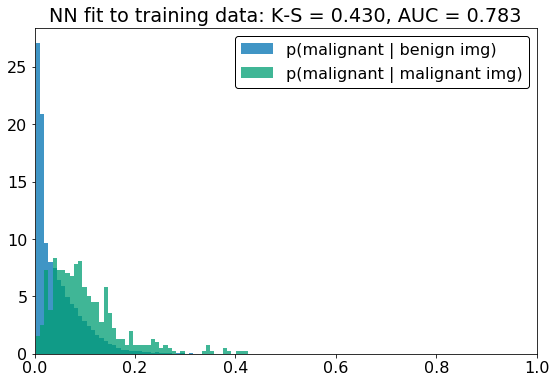

In [11]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

nn_train_predictions = X_train[:, -1]

counts, bins = np.histogram(np.array(nn_train_predictions), bins=50)
plt.hist(nn_train_predictions[y_train==0], 
         density=True, bins=bins, label='p(malignant | benign img) ', alpha=.75)
plt.hist(nn_train_predictions[y_train==1],
         density=True, bins=bins, label='p(malignant | malignant img)', alpha=.75)

ks, p = ks_2samp(nn_train_predictions[y_train==0], 
                          nn_train_predictions[y_train==1])
fpr, tpr, _ = roc_curve(y_train, nn_train_predictions)
roc_auc = auc(fpr, tpr)

plt.xlim([0, 1])
plt.legend()
plt.title("NN fit to training data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))
plt.show()

In [12]:
'''
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

train_predictions = bst.predict(xgb.DMatrix(X_train_std))

counts, bins = np.histogram(np.array(train_predictions), bins=50)
plt.hist(train_predictions[y_train==0], 
         density=True, bins=bins, label='p(malignant | benign img) ', alpha=.75)
plt.hist(train_predictions[y_train==1],
         density=True, bins=bins, label='p(malignant | malignant img)', alpha=.75)

ks, p = ks_2samp(train_predictions[y_train==0], 
                           train_predictions[y_train==1])
fpr, tpr, _ = roc_curve(y_train, train_predictions)
roc_auc = auc(fpr, tpr)

plt.xlim([0, 1])
plt.legend()
plt.title("XGB fit to training data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))
plt.show()
'''

'\nplt.style.use(\'seaborn-colorblind\')\nplt.rcParams.update({\'font.size\': 16, \n                     \'legend.framealpha\':1, \n                     \'legend.edgecolor\':\'inherit\'}) \nplt.figure(figsize=(9, 6))\n\ntrain_predictions = bst.predict(xgb.DMatrix(X_train_std))\n\ncounts, bins = np.histogram(np.array(train_predictions), bins=50)\nplt.hist(train_predictions[y_train==0], \n         density=True, bins=bins, label=\'p(malignant | benign img) \', alpha=.75)\nplt.hist(train_predictions[y_train==1],\n         density=True, bins=bins, label=\'p(malignant | malignant img)\', alpha=.75)\n\nks, p = ks_2samp(train_predictions[y_train==0], \n                           train_predictions[y_train==1])\nfpr, tpr, _ = roc_curve(y_train, train_predictions)\nroc_auc = auc(fpr, tpr)\n\nplt.xlim([0, 1])\nplt.legend()\nplt.title("XGB fit to training data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))\nplt.show()\n'

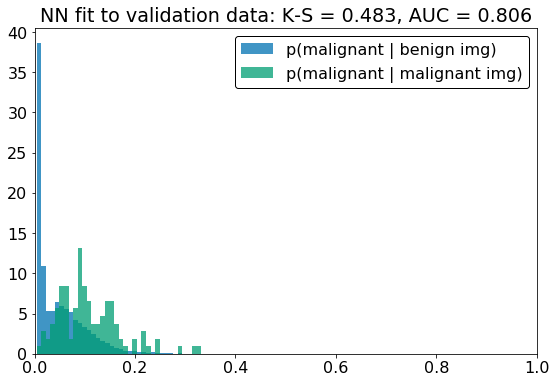

In [26]:
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

valid_pred = X_valid[:, -1] #nn_oof[inds]
y_valid = val_df['target'].values #train_df_allsamples['target'].values[inds]

counts, bins = np.histogram(np.array(valid_pred), bins=50)
plt.hist(valid_pred[y_valid==0], 
         density=True, bins=bins, label='p(malignant | benign img) ', alpha=.75)
plt.hist(valid_pred[y_valid==1],
         density=True, bins=bins, label='p(malignant | malignant img)', alpha=.75)

ks, p = ks_2samp(valid_pred[y_valid==0], 
                 valid_pred[y_valid==1])

fpr, tpr, _ = roc_curve(y_valid, valid_pred)
roc_auc = auc(fpr, tpr)

plt.xlim([0, 1])
plt.legend()
plt.title("NN fit to validation data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))
plt.show()

In [27]:
val_df['target'].values

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [28]:
train_df_allsamples['target'].values[inds]

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [14]:
'''plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16, 
                     'legend.framealpha':1, 
                     'legend.edgecolor':'inherit'}) 
plt.figure(figsize=(9, 6))

valid_pred = xgb_oof
y_valid = train_df_allsamples['target'].values

counts, bins = np.histogram(np.array(valid_pred), bins=50)
plt.hist(valid_pred[y_valid==0], 
         density=True, bins=bins, label='p(malignant | benign img) ', alpha=.75)
plt.hist(valid_pred[y_valid==1],
         density=True, bins=bins, label='p(malignant | malignant img)', alpha=.75)

ks, p = ks_2samp(valid_pred[y_valid==0], 
                 valid_pred[y_valid==1])

fpr, tpr, _ = roc_curve(y_valid, valid_pred)
roc_auc = auc(fpr, tpr)

plt.xlim([0, 1])
plt.legend()
plt.title("XGB fit to validation data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))
plt.show()'''

'plt.style.use(\'seaborn-colorblind\')\nplt.rcParams.update({\'font.size\': 16, \n                     \'legend.framealpha\':1, \n                     \'legend.edgecolor\':\'inherit\'}) \nplt.figure(figsize=(9, 6))\n\nvalid_pred = xgb_oof\ny_valid = train_df_allsamples[\'target\'].values\n\ncounts, bins = np.histogram(np.array(valid_pred), bins=50)\nplt.hist(valid_pred[y_valid==0], \n         density=True, bins=bins, label=\'p(malignant | benign img) \', alpha=.75)\nplt.hist(valid_pred[y_valid==1],\n         density=True, bins=bins, label=\'p(malignant | malignant img)\', alpha=.75)\n\nks, p = ks_2samp(valid_pred[y_valid==0], \n                 valid_pred[y_valid==1])\n\nfpr, tpr, _ = roc_curve(y_valid, valid_pred)\nroc_auc = auc(fpr, tpr)\n\nplt.xlim([0, 1])\nplt.legend()\nplt.title("XGB fit to validation data: K-S = {:.3f}, AUC = {:.3f}".format(ks, roc_auc))\nplt.show()'

In [22]:
image_names = test_df['image_name'].values

submission = pd.DataFrame()
submission["image_name"] = image_names
submission["target"] = predictions
submission.to_csv("simple_submission.csv", index=False)
submission.head(50)

,image_name,target
0,ISIC_0052060,0.025790
1,ISIC_0052349,0.013293
2,ISIC_0058510,0.008284
3,ISIC_0073313,0.008540
4,ISIC_0073502,0.031819
5,ISIC_0074618,0.037593
6,ISIC_0076801,0.041971
7,ISIC_0077586,0.089719
8,ISIC_0082004,0.064761
9,ISIC_0082785,0.111828
